# Human Activity Recognition Using Smartphones

The Human Activity Recognition database is built from the recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors.

The goal of the Final Project is to predict the type of activity of the subject from the inertial sensor data recorded from the waist-mounted smartphones 

In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report

## Get the Training and Test Data

In [2]:
# get the features
feature_file = 'data/features.txt'

features = []
with open(feature_file, 'r') as file:
    for line in file:
        columns = line.split()
        features.append(columns[1])

print('No. of Features: {}'.format(len(features)))


No. of Features: 561


In [3]:
# find duplicate features and print

df_features = pd.DataFrame(features, columns=['features'])
print(df_features[df_features.duplicated()])

                          features
316     fBodyAcc-bandsEnergy()-1,8
317    fBodyAcc-bandsEnergy()-9,16
318   fBodyAcc-bandsEnergy()-17,24
319   fBodyAcc-bandsEnergy()-25,32
320   fBodyAcc-bandsEnergy()-33,40
..                             ...
497  fBodyGyro-bandsEnergy()-17,32
498  fBodyGyro-bandsEnergy()-33,48
499  fBodyGyro-bandsEnergy()-49,64
500   fBodyGyro-bandsEnergy()-1,24
501  fBodyGyro-bandsEnergy()-25,48

[84 rows x 1 columns]


In [4]:
# create a list of unique features by appending '_' at the end of the feature till the 
# length of the unique feature list matches that of the original list of features

seen = set()
uniq_features = []
for idx, x in enumerate(features):
    if x not in seen:
        uniq_features.append(x)
        seen.add(x)
    elif x + 'n' not in seen:
        uniq_features.append(x + '_')
        seen.add(x + 'n')
    else:
        uniq_features.append(x + '__')
        seen.add(x + 'nn')
print("Length of unique features = " + str(len(uniq_features)))


Length of unique features = 561


In [5]:
# get the training data from txt files to pandas dataffame
X_train = pd.read_csv('data/train/X_train.txt', delim_whitespace=True, header=None, names=uniq_features)

# # add subject column to the dataframe
X_train['subject'] = pd.read_csv('data/train/subject_train.txt', header=None)

# read y_train
y_train = pd.read_csv('data/train/y_train.txt', names=['Activity'])

# define the activity name and add to y_train
def map_labels(value):
    label_map = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}
    return label_map[value]

y_train_labels = y_train['Activity'].map(map_labels)

# put all columns in a single dataframe
train = X_train.copy()
train['Activity'] = y_train.copy()
train['ActivityName'] = y_train_labels.copy()
train.sample()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
2930,0.276343,-0.013558,-0.10769,-0.996497,-0.995459,-0.98804,-0.997391,-0.994888,-0.98923,-0.937397,...,0.117709,-0.556074,-0.423989,0.302293,-0.880816,0.116257,0.102945,16,4,SITTING


In [6]:
# get the test data from txt files to pandas dataffame
X_test = pd.read_csv('data/test/X_test.txt', delim_whitespace=True, header=None, names=uniq_features)

# add subject column to the dataframe
X_test['subject'] = pd.read_csv('data/test/subject_test.txt', header=None)

# read y_test
y_test = pd.read_csv('data/test/y_test.txt', names=['Activity'])

# define the activity name and add to y_test
def map_labels(value):
    label_map = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}
    return label_map[value]

y_test_labels = y_test['Activity'].map(map_labels)

# put all columns in a single dataframe
test = X_test.copy()
test['Activity'] = y_test.copy()
test['ActivityName'] = y_test_labels.copy()
test.sample()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
1261,0.313998,-0.010338,-0.11866,-0.964557,-0.930796,-0.960774,-0.965245,-0.937207,-0.960017,-0.903999,...,0.015988,0.881288,0.341913,-0.309448,0.498048,-0.318352,-0.68922,12,6,LAYING


## Data Check

Check for duplicate and nan/null values in the test and training data

In [7]:
# count duplicated and null values in train and test

train_duplicate = sum(train.duplicated())
test_duplicate  = sum(test.duplicated())
train_null = train.isnull().values.sum()
test_null  = test.isnull().values.sum()

print("Duplicates in training set = " + str(train_duplicate))
print("Duplicates in test set = " + str(test_duplicate))
print("Nulls in training set = " + str(train_null))
print("Nulls in test set = " + str(test_null))

Duplicates in training set = 0
Duplicates in test set = 0
Nulls in training set = 0
Nulls in test set = 0


## Renaming Data Columns

In [8]:
columns = train.columns

# Removing '()', '-', ',' from column names
columns = columns.str.replace('()','')
columns = columns.str.replace('-', '')
columns = columns.str.replace(',','')

train.columns = columns
test.columns = columns

## Statistical Analysis

In the following cell, we look at a small slice of the data to gain some insight.

Here we calculate the mean value of the first 12 columns of the training dataset grouped by the activity names. We observe that the walking activities (walking, walking upstairs and walking downstairs) can be differentiated from the rest by tBodyAccstdX, tBodyAccstdY and tBodyAccstdZ. The mean value of tBodyAccmaxX shows that all the walking activities can also be differentiated between each other.

In [9]:
# shape of the train and test data
print("Train data shape: ", train.shape)
print("Test data shape: ", test.shape)


Train data shape:  (7352, 564)
Test data shape:  (2947, 564)


In [10]:
# Statistical summary of the train data
train.describe()


,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,...,fBodyBodyGyroJerkMagkurtosis,angle(tBodyAccMeangravity),angle(tBodyAccJerkMean)gravityMean),angle(tBodyGyroMeangravityMean),angle(tBodyGyroJerkMeangravityMean),angle(XgravityMean),angle(YgravityMean),angle(ZgravityMean),subject,Activity
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085,3.643362
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143,1.744802
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000,2.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000,4.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000,6.000000


In [11]:
# Statistical summary of the test data
test.describe()

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,...,fBodyBodyGyroJerkMagkurtosis,angle(tBodyAccMeangravity),angle(tBodyAccJerkMean)gravityMean),angle(tBodyGyroMeangravityMean),angle(tBodyGyroJerkMeangravityMean),angle(XgravityMean),angle(YgravityMean),angle(ZgravityMean),subject,Activity
count,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,...,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000
mean,0.273996,-0.017863,-0.108386,-0.613635,-0.508330,-0.633797,-0.641278,-0.522676,-0.637038,-0.462063,...,-0.598756,0.005264,0.003799,0.040029,-0.017298,-0.513923,0.074886,-0.048720,12.986427,3.577876
std,0.060570,0.025745,0.042747,0.412597,0.494269,0.362699,0.385199,0.479899,0.357753,0.523916,...,0.311042,0.336147,0.445077,0.634989,0.501311,0.509205,0.324300,0.241467,6.950984,1.740348
min,-0.592004,-0.362884,-0.576184,-0.999606,-1.000000,-0.998955,-0.999417,-0.999914,-0.998899,-0.952357,...,-1.000000,-1.000000,-0.993402,-0.998898,-0.991096,-0.984195,-0.913704,-0.949228,2.000000,1.000000
25%,0.262075,-0.024961,-0.121162,-0.990914,-0.973664,-0.976122,-0.992333,-0.974131,-0.975352,-0.934447,...,-0.829593,-0.130541,-0.282600,-0.518924,-0.428375,-0.829722,0.022140,-0.098485,9.000000,2.000000
50%,0.277113,-0.016967,-0.108458,-0.931214,-0.790972,-0.827534,-0.937664,-0.799907,-0.817005,-0.852659,...,-0.683672,0.005188,0.006767,0.047113,-0.026726,-0.729648,0.181563,-0.010671,12.000000,4.000000
75%,0.288097,-0.010143,-0.097123,-0.267395,-0.105919,-0.311432,-0.321719,-0.133488,-0.322771,-0.009965,...,-0.458332,0.146200,0.288113,0.622151,0.394387,-0.545939,0.260252,0.092373,18.000000,5.000000
max,0.671887,0.246106,0.494114,0.465299,1.000000,0.489703,0.439657,1.000000,0.427958,0.786436,...,1.000000,0.998898,0.986347,1.000000,1.000000,0.833180,1.000000,0.973113,24.000000,6.000000


In [12]:
# data types of the columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 564 entries, tBodyAccmeanX to ActivityName
dtypes: float64(561), int64(2), object(1)
memory usage: 31.6+ MB


In [13]:
# object data types
train.select_dtypes(include=['object']).columns

Index(['ActivityName'], dtype='object')

In [14]:
# float data types
train.select_dtypes(include=['float']).columns

Index(['tBodyAccmeanX', 'tBodyAccmeanY', 'tBodyAccmeanZ', 'tBodyAccstdX',
       'tBodyAccstdY', 'tBodyAccstdZ', 'tBodyAccmadX', 'tBodyAccmadY',
       'tBodyAccmadZ', 'tBodyAccmaxX',
       ...
       'fBodyBodyGyroJerkMagmeanFreq', 'fBodyBodyGyroJerkMagskewness',
       'fBodyBodyGyroJerkMagkurtosis', 'angle(tBodyAccMeangravity)',
       'angle(tBodyAccJerkMean)gravityMean)',
       'angle(tBodyGyroMeangravityMean)',
       'angle(tBodyGyroJerkMeangravityMean)', 'angle(XgravityMean)',
       'angle(YgravityMean)', 'angle(ZgravityMean)'],
      dtype='object', length=561)

In [21]:
# calculate the mean after grouping based on ActivityName
grouped = train.groupby('ActivityName')

mean_values = grouped.mean()
for i in range(12):
    col = mean_values.iloc[:,i]
    print(col)
    print('')

ActivityName
LAYING                0.269191
SITTING               0.273449
STANDING              0.279294
WALKING               0.276260
WALKING_DOWNSTAIRS    0.288169
WALKING_UPSTAIRS      0.261930
Name: tBodyAccmeanX, dtype: float64

ActivityName
LAYING               -0.018345
SITTING              -0.012143
STANDING             -0.016123
WALKING              -0.017768
WALKING_DOWNSTAIRS   -0.016370
WALKING_UPSTAIRS     -0.026647
Name: tBodyAccmeanY, dtype: float64

ActivityName
LAYING               -0.107169
SITTING              -0.106581
STANDING             -0.107330
WALKING              -0.108884
WALKING_DOWNSTAIRS   -0.105860
WALKING_UPSTAIRS     -0.120424
Name: tBodyAccmeanZ, dtype: float64

ActivityName
LAYING               -0.959475
SITTING              -0.983450
STANDING             -0.985346
WALKING              -0.312641
WALKING_DOWNSTAIRS    0.139847
WALKING_UPSTAIRS     -0.221072
Name: tBodyAccstdX, dtype: float64

ActivityName
LAYING               -0.937609
SITTING      

## Visualizing the Data

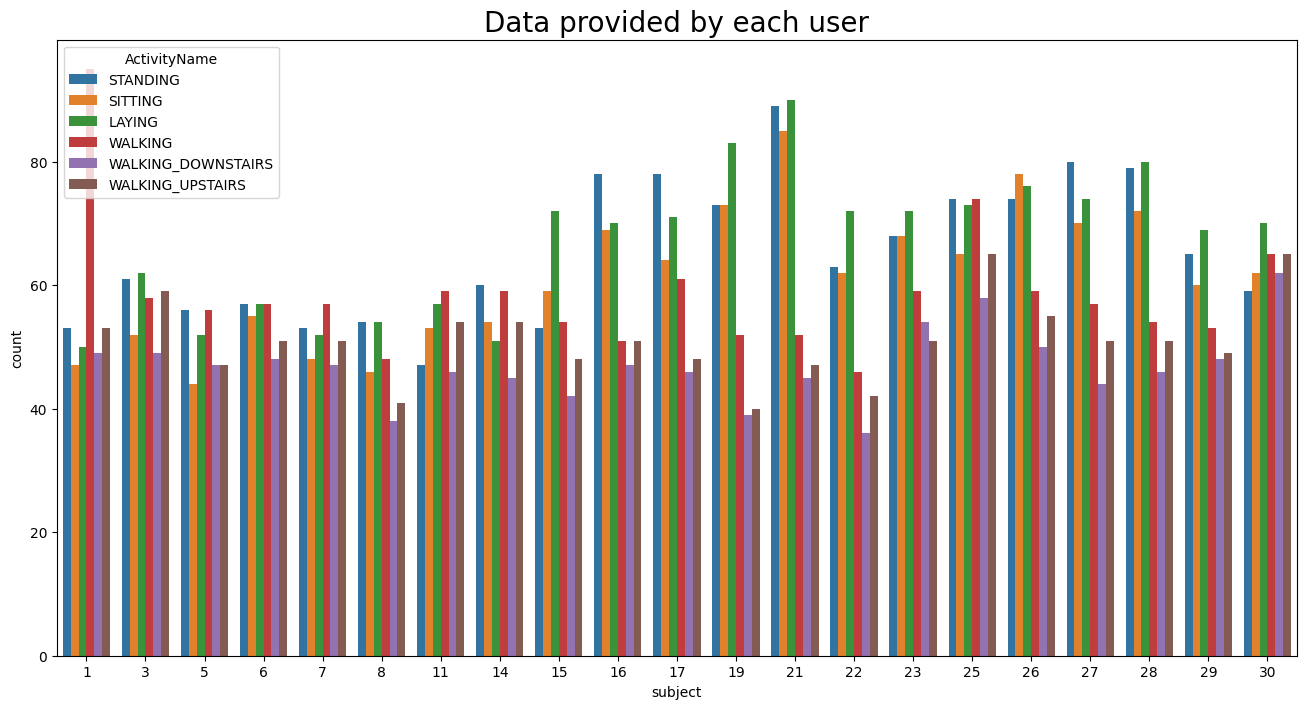

In [15]:
# check for data imbalance
plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject',hue='ActivityName', data = train)
plt.show()


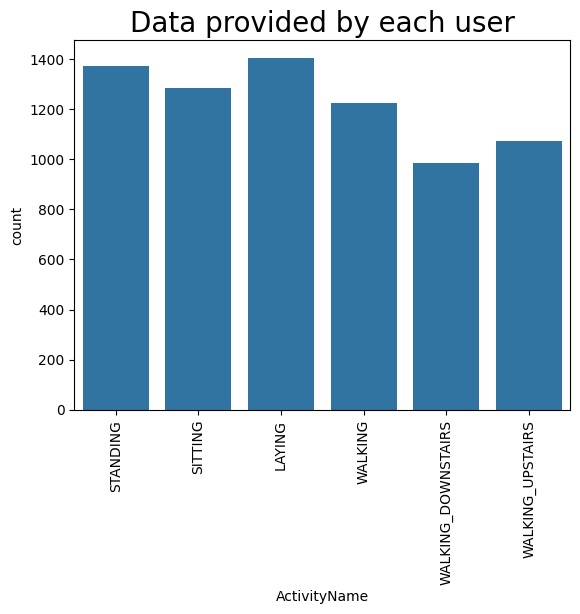

In [16]:
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='ActivityName', data = train)
plt.xticks(rotation=90)
plt.show()

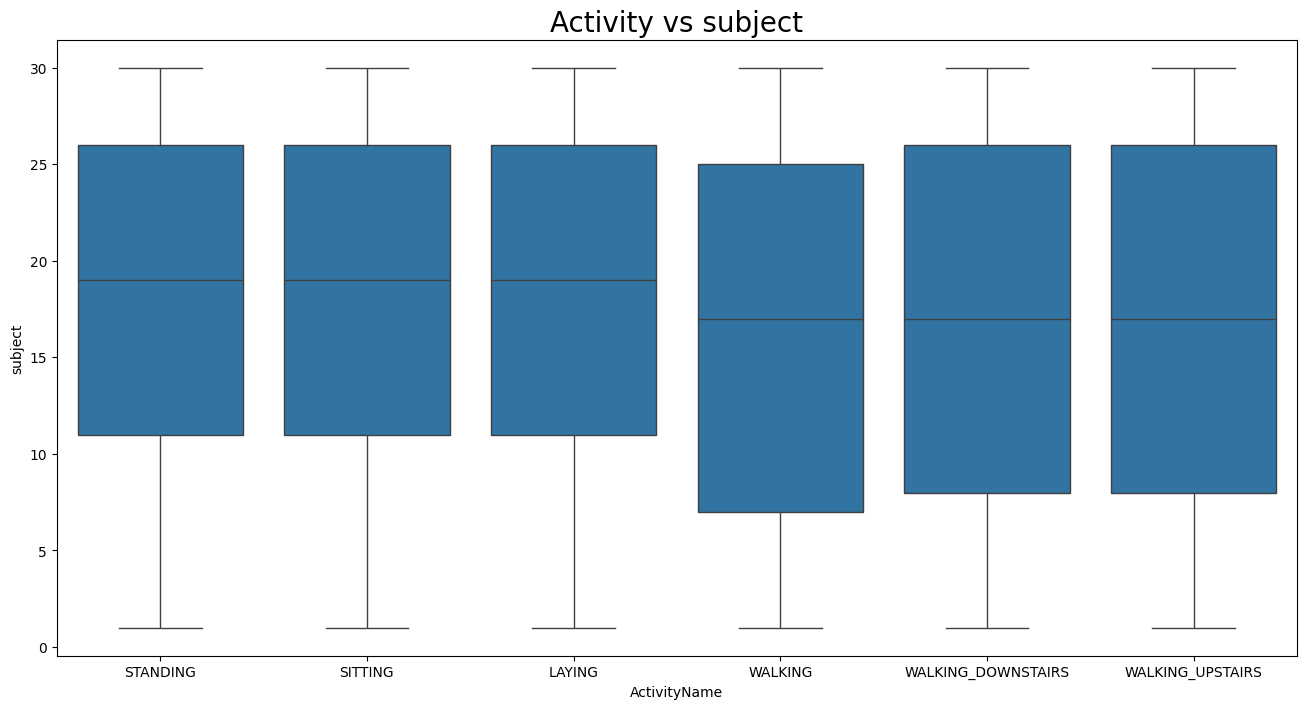

In [17]:
# box plot of activity vs subject
plt.figure(figsize=(16,8))
plt.title('Activity vs subject', fontsize=20)
sns.boxplot(x='ActivityName', y='subject', data = train, showfliers=False)
plt.show()


Number of Accelerometer columns:  345
Number of Gyroscope columns:  213
Number of other columns:  6


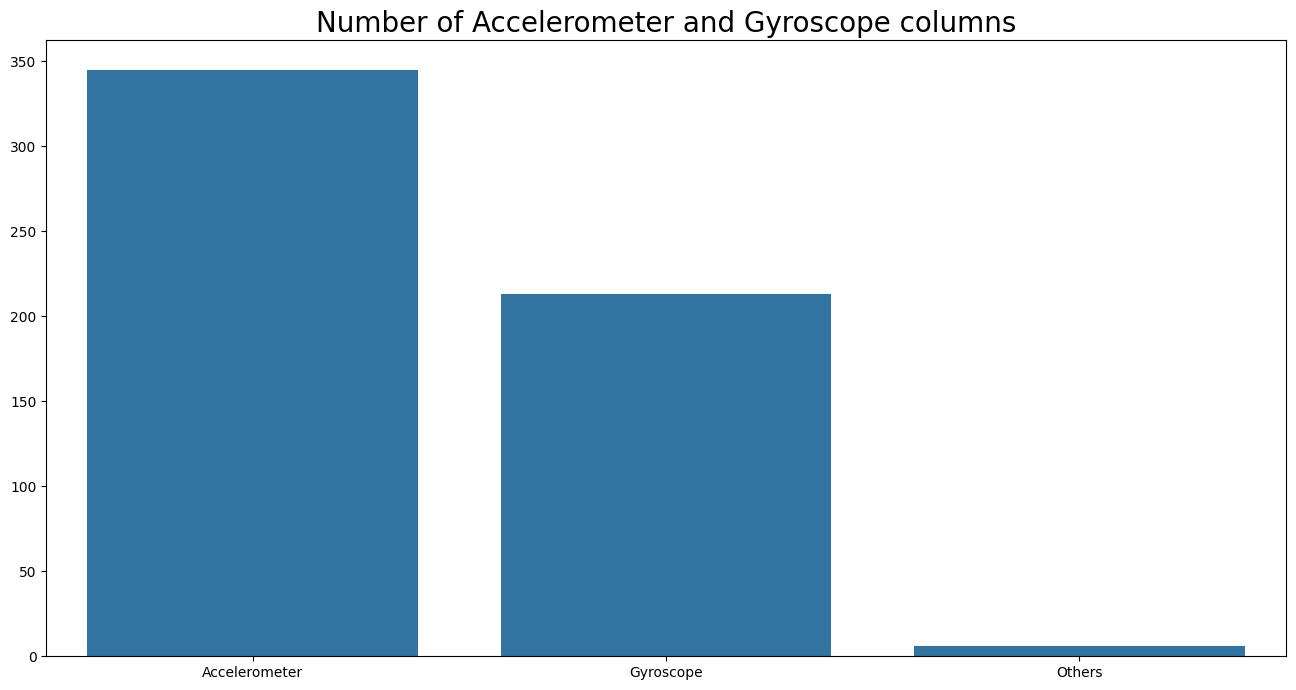

In [20]:
# check for the different sensors available

Acc = [col for col in train.columns if 'Acc' in col]
Gyro = [col for col in train.columns if 'Gyro' in col]
Other = [col for col in train.columns if 'Acc' not in col and 'Gyro' not in col]

print("Number of Accelerometer columns: ", len(Acc))
print("Number of Gyroscope columns: ", len(Gyro))
print("Number of other columns: ", len(Other))

# plot the number of accelerometer and gyroscope columns
plt.figure(figsize=(16,8))
plt.title('Number of Accelerometer and Gyroscope columns', fontsize=20)
sns.barplot(x=['Accelerometer', 'Gyroscope', 'Others'], y=[len(Acc), len(Gyro), len(Other)])
plt.show()


In [24]:
import plotly.express as px

fig = px.histogram(train, x='tBodyAccMagmean', color='ActivityName', marginal='box', nbins=50, title='tBodyAccMagmean() vs ActivityName')
fig.update_layout(bargap=0.1)
fig.show()


In [25]:
# Now consider the angle(XgravityMean) to differentiate between static and dynamic activities using pdf

fig = px.histogram(train, x='angle(XgravityMean)', color='ActivityName', marginal='box', nbins=50, title='angle(XgravityMean) vs ActivityName')
fig.update_layout(bargap=0.1)
fig.show()



In the cell below, we create 2D plots of a slice of the data. 

We plot the data in successive columns for the first 9 columns. We observe that some of the data can be separated based on the tBodyAccstd-X,Y,Z and tBodyAccmad-X,Y,Z data. 

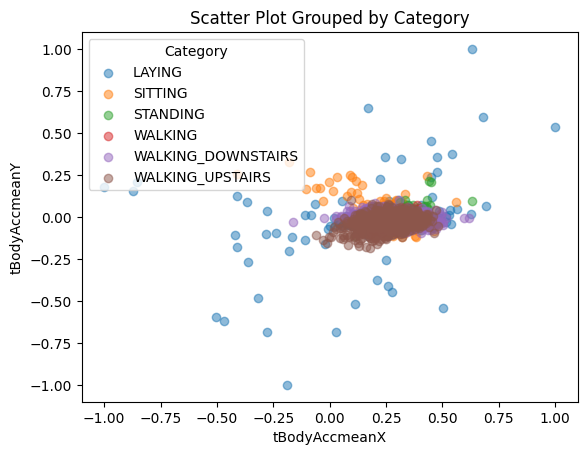

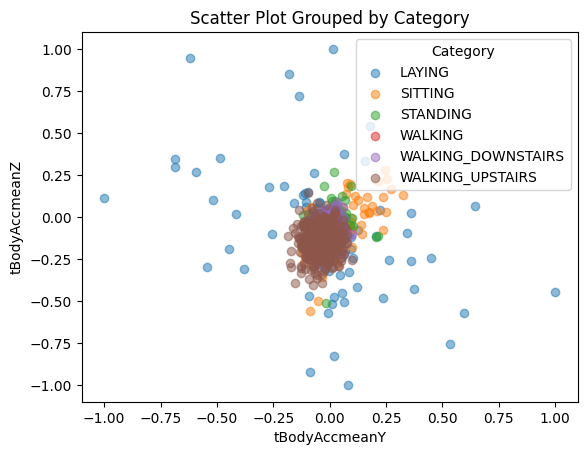

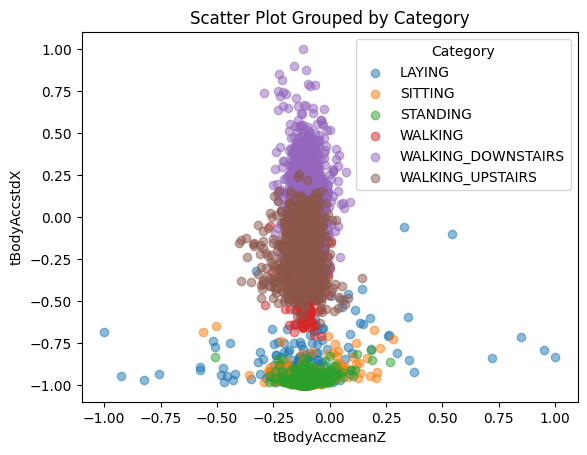

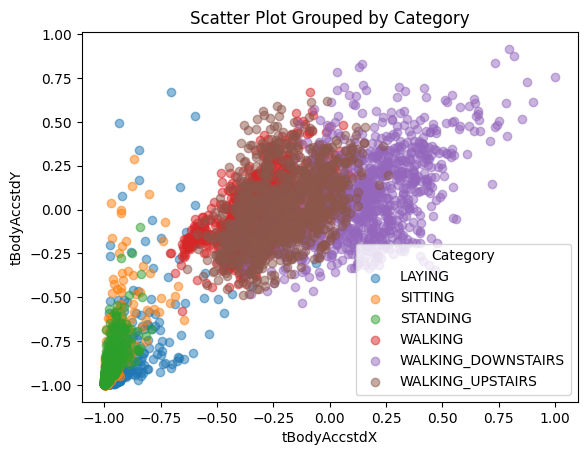

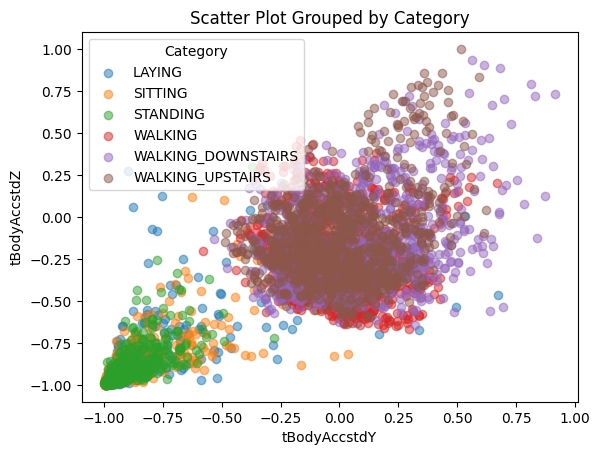

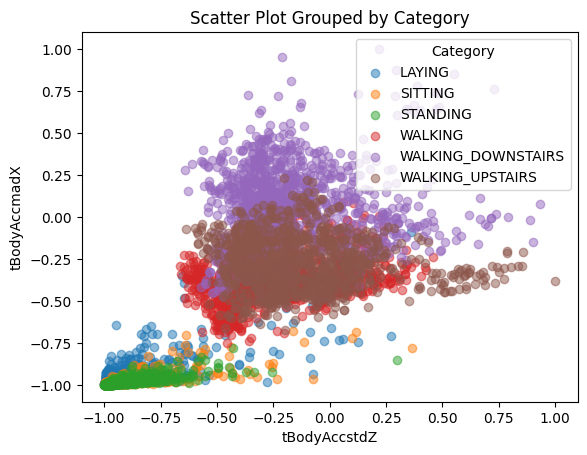

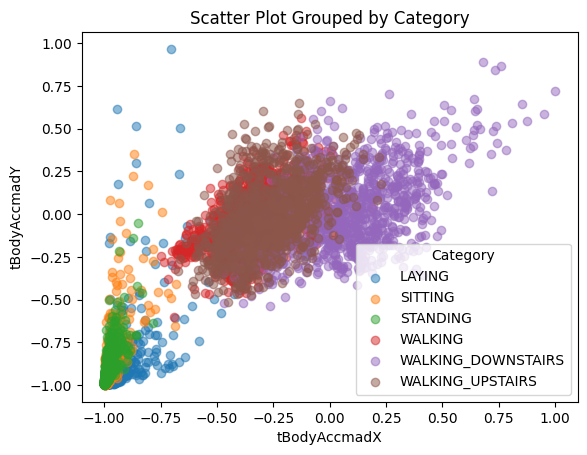

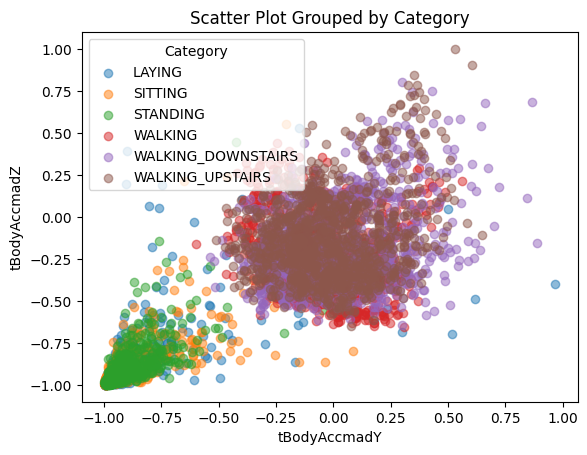

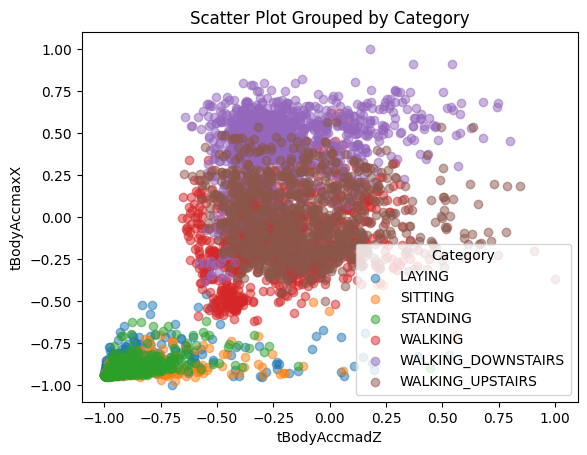

In [83]:
# visualizing the data by plotting succesive columns
column_names = train.columns

for i in range(9):
    for name, group in grouped:
        colx = column_names[i]
        coly = column_names[i+1]
        plt.figure(i)
        plt.scatter(group[colx], group[coly], label=name, alpha = 0.5)
        plt.xlabel(colx)
        plt.ylabel(coly)
        plt.title('Scatter Plot Grouped by Category')
        plt.legend(title='Category')
   

<Axes: xlabel='ActivityName', ylabel='count'>

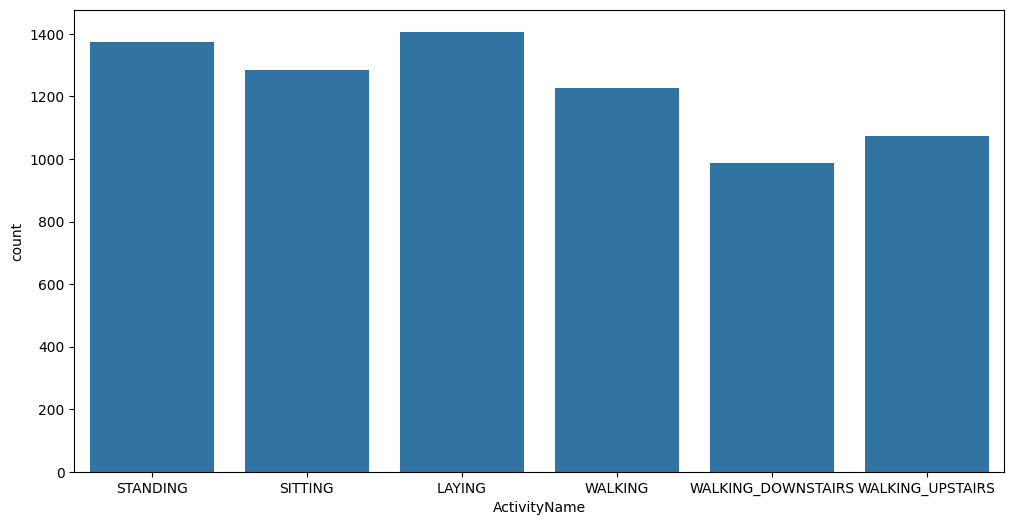

In [78]:
## Create frequency plot of activity labels

plt.figure(figsize=(12,6))
sns.countplot(x=train['ActivityName'])

## Correlation Analysis


In [79]:
# import library
from sklearn.feature_selection import SelectKBest, f_classif

k_user = 100 # chosen by trial and error so that SVC accuracy is >= 90%

# use SelectKBest to find k_user number of features to use
selector = SelectKBest(score_func=f_classif, k=k_user)
y_train_ = y_train.values.reshape(-1)
X_train_new = selector.fit_transform(X_train, y_train_)

# get column names which are selected
selected_indices = selector.get_support(indices=True)
column_names = list(X_train.columns)
selected_column_names = [column_names[i] for i in selected_indices]
print("Selected column names:", selected_column_names)

Selected column names: ['tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-max()-X', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-sma()', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tGravityAcc-mean()-X', 'tGravityAcc-max()-X', 'tGravityAcc-min()-X', 'tGravityAcc-energy()-X', 'tBodyAccJerk-std()-X', 'tBodyAccJerk-std()-Y', 'tBodyAccJerk-mad()-X', 'tBodyAccJerk-mad()-Y', 'tBodyAccJerk-max()-X', 'tBodyAccJerk-min()-X', 'tBodyAccJerk-sma()', 'tBodyAccJerk-iqr()-X', 'tBodyAccJerk-iqr()-Y', 'tBodyAccJerk-entropy()-X', 'tBodyAccJerk-entropy()-Y', 'tBodyAccJerk-entropy()-Z', 'tBodyGyro-sma()', 'tBodyGyroJerk-entropy()-X', 'tBodyGyroJerk-entropy()-Y', 'tBodyGyroJerk-entropy()-Z', 'tBodyAccMag-mean()', 'tBodyAccMag-std()', 'tBodyAccMag-mad()', 'tBodyAccMag-max()', 'tBodyAccMag-sma()', 'tBodyAccMag-entropy()', 'tGravityAccMag-mean()', 'tGravityAccMag-std()', 'tGravityAccMag-mad()', 'tGravityAccMag-max()', 'tGravityAccMag-sma()', 'tGravityAccMag-entropy()'

In [ ]:
# check multicollinearity using variance inflation factor

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(train.drop(['subject', 'Activity', 'ActivityName'], axis=1))
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# drop the columns with high VIF
vif = vif.sort_values(by='VIF', ascending=False)
vif.head(10)

# drop the columns with high VIF
high_vif = vif[vif['VIF'] > 10]
high_vif


## Classification
### Support Vector Machine Classifier

In [80]:
# SVC - with all 561 features

svc = SVC(random_state=42)
y_train_ = y_train.values.reshape(-1)
svc.fit(X_train, y_train_)

# Predict
y_pred = svc.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           1       0.90      1.00      0.94       496
           2       0.94      0.95      0.94       471
           3       0.99      0.85      0.92       420
           4       0.90      0.86      0.88       491
           5       0.88      0.92      0.90       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



In [82]:
# SVC - with k_user number of features

svc = SVC(random_state=42)
svc.fit(X_train_new, y_train_)

X_test_new = X_test.iloc[:,selected_indices]

# Predict
y_pred = svc.predict(X_test_new.values)

# Classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           1       0.89      0.99      0.94       496
           2       0.92      0.91      0.91       471
           3       0.98      0.87      0.92       420
           4       0.87      0.71      0.78       491
           5       0.77      0.90      0.83       532
           6       1.00      1.00      1.00       537

    accuracy                           0.90      2947
   macro avg       0.91      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947

